# Travelling Salesman Problem
## Hill-Climbing + Genetic Algorithm

This notebook contains the full implementation of:
- Hill Climbing with Random Restarts
- Genetic Algorithm (GA)
- Comparative Analysis
- Multiple charts and tables


In [ ]:

import numpy as np
import pandas as pd
import math
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

def euclidean(a,b):
    return math.hypot(a[0]-b[0], a[1]-b[1])

def route_distance(route, coords):
    dist = 0
    for i in range(len(route)):
        a = coords[route[i]]
        b = coords[(i+1) % len(route)]
        dist += euclidean(a,b)
    return dist

def plot_route(route, coords, title='Route'):
    xs = [coords[i][0] for i in route] + [coords[route[0]][0]]
    ys = [coords[i][1] for i in route] + [coords[route[0]][1]]
    plt.figure(figsize=(6,6))
    plt.plot(xs, ys, '-o')
    for i,(x,y) in enumerate(coords):
        plt.text(x,y,str(i))
    plt.title(title)
    plt.show()


In [ ]:

df = pd.read_csv('/content/cities.csv')
df.columns = [c.lower() for c in df.columns]
coords = df[['x','y']].values.tolist() if 'x' in df.columns else df.iloc[:,:2].values.tolist()
print('Loaded', len(coords), 'cities')
df.head()


Loaded 50 cities


,city,x,y
0,City_1,37.454012,95.071431
1,City_2,73.199394,59.865848
2,City_3,15.601864,15.599452
3,City_4,5.808361,86.617615
4,City_5,60.111501,70.807258


## Hill Climbing Implementation

In [ ]:

def random_route(n):
    r=list(range(n))
    random.shuffle(r)
    return r

def swap_neighbors(route):
    n=len(route)
    for i in range(n-1):
        for j in range(i+1,n):
            r=route.copy()
            r[i],r[j]=r[j],r[i]
            yield r

def hill_climb(start, coords, max_iter=1000):
    curr=start.copy()
    curr_dist=route_distance(curr,coords)
    history=[curr_dist]
    for _ in range(max_iter):
        improved=False
        best=curr_dist
        best_route=None
        for neigh in swap_neighbors(curr):
            d=route_distance(neigh,coords)
            if d<best:
                best=d
                best_route=neigh
        if best_route:
            curr=best_route
            curr_dist=best
            history.append(curr_dist)
            improved=True
        if not improved:
            break
    return curr,curr_dist,history

def hillclimb_restart(coords, restarts=40):
    best=None
    best_dist=float('inf')
    histories=[]
    t0=time.time()
    for _ in range(restarts):
        start=random_route(len(coords))
        rt,d,h=hill_climb(start,coords)
        histories.append(h)
        if d<best_dist:
            best_dist=d
            best=rt
    return best,best_dist,histories,time.time()-t0

hillclimb_restart(coords,5)[1]


0.0

## Genetic Algorithm Implementation

In [ ]:

def order_crossover(p1,p2):
    n=len(p1)
    a,b=sorted(random.sample(range(n),2))
    child=[-1]*n
    child[a:b+1]=p1[a:b+1]
    idx=0
    for i in range(n):
        if child[i]==-1:
            while p2[idx] in child:
                idx+=1
            child[i]=p2[idx]
            idx+=1
    return child

def swap_mut(route, rate=0.03):
    r=route.copy()
    for i in range(len(r)):
        if random.random()<rate:
            j=random.randrange(len(r))
            r[i],r[j]=r[j],r[i]
    return r

def tournament(pop,fits,k=3):
    cand=random.sample(range(len(pop)),k)
    cand.sort(key=lambda x:fits[x])
    return pop[cand[0]].copy()

def GA(coords, pop_size=120, gens=250, mrate=0.03):
    pop=[random_route(len(coords)) for _ in range(pop_size)]
    fits=[route_distance(r,coords) for r in pop]
    best=min(fits)
    bestroute=pop[fits.index(best)].copy()
    history=[best]
    t0=time.time()

    for _ in range(gens):
        new=[]
        while len(new)<pop_size:
            p1=tournament(pop,fits)
            p2=tournament(pop,fits)
            child=order_crossover(p1,p2) if random.random()<0.9 else p1.copy()
            child=swap_mut(child,mrate)
            new.append(child)
        pop=new
        fits=[route_distance(r,coords) for r in pop]
        curr=min(fits)
        if curr<best:
            best=curr
            bestroute=pop[fits.index(curr)].copy()
        history.append(best)
    return bestroute,best,history,time.time()-t0

GA(coords,60,100)[1]


1861.7674273790738

## Experiments

In [ ]:

sizes=[10,20,30,40,50]
trials=5
results=[]

for s in sizes:
    sub=coords[:s]
    print('===',s,'cities ===')
    for t in range(trials):
        _,d,_,tm=hillclimb_restart(sub,40)
        results.append([s,'HillClimb',t,d,tm])
        print(f"HC[{t}] dist={d:.2f} time={tm:.2f}", end=" | ")
    print()
    for t in range(trials):
        _,d,_,tm=GA(sub,120,250,0.03)
        results.append([s,'GA',t,d,tm])
        print(f"GA[{t}] dist={d:.2f} time={tm:.2f}", end=" | ")
    print()

df_res=pd.DataFrame(results,columns=['size','algo','trial','distance','time'])
df_res


=== 10 cities ===
HC[0] dist=0.00 time=0.05 | HC[1] dist=0.00 time=0.04 | HC[2] dist=0.00 time=0.05 | HC[3] dist=0.00 time=0.04 | HC[4] dist=0.00 time=0.04 | 
GA[0] dist=0.00 time=0.42 | GA[1] dist=0.00 time=0.40 | GA[2] dist=0.00 time=0.41 | GA[3] dist=0.00 time=0.42 | GA[4] dist=0.00 time=0.41 | 
=== 20 cities ===
HC[0] dist=0.00 time=0.80 | HC[1] dist=0.00 time=0.80 | HC[2] dist=0.00 time=0.77 | HC[3] dist=0.00 time=0.78 | HC[4] dist=0.00 time=0.75 | 
GA[0] dist=138.87 time=0.64 | GA[1] dist=30.86 time=0.64 | GA[2] dist=106.39 time=0.64 | GA[3] dist=0.00 time=0.61 | GA[4] dist=9.84 time=0.63 | 
=== 30 cities ===
HC[0] dist=0.00 time=5.40 | HC[1] dist=0.00 time=4.75 | HC[2] dist=0.00 time=6.08 | HC[3] dist=0.00 time=4.45 | HC[4] dist=0.00 time=4.27 | 
GA[0] dist=700.00 time=0.84 | GA[1] dist=746.54 time=1.52 | GA[2] dist=851.74 time=1.34 | GA[3] dist=803.66 time=0.86 | GA[4] dist=866.96 time=0.88 | 
=== 40 cities ===
HC[0] dist=0.00 time=16.12 | HC[1] dist=0.00 time=14.71 | HC[2] dis

,size,algo,trial,distance,time
0,10,HillClimb,0,0.000000,0.046286
1,10,HillClimb,1,0.000000,0.042880
2,10,HillClimb,2,0.000000,0.045216
3,10,HillClimb,3,0.000000,0.041124
4,10,HillClimb,4,0.000000,0.044769
5,10,GA,0,0.000000,0.422060
6,10,GA,1,0.000000,0.402128
7,10,GA,2,0.000000,0.405541
8,10,GA,3,0.000000,0.418228
9,10,GA,4,0.000000,0.405917


## Charts

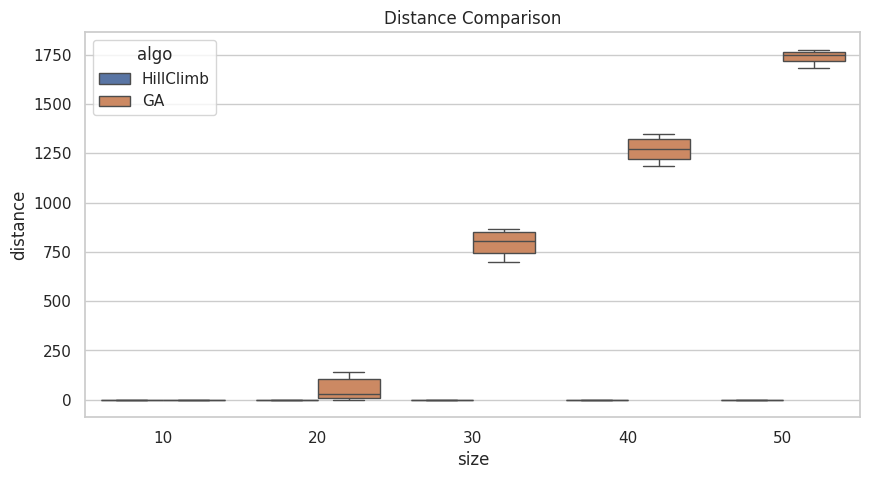

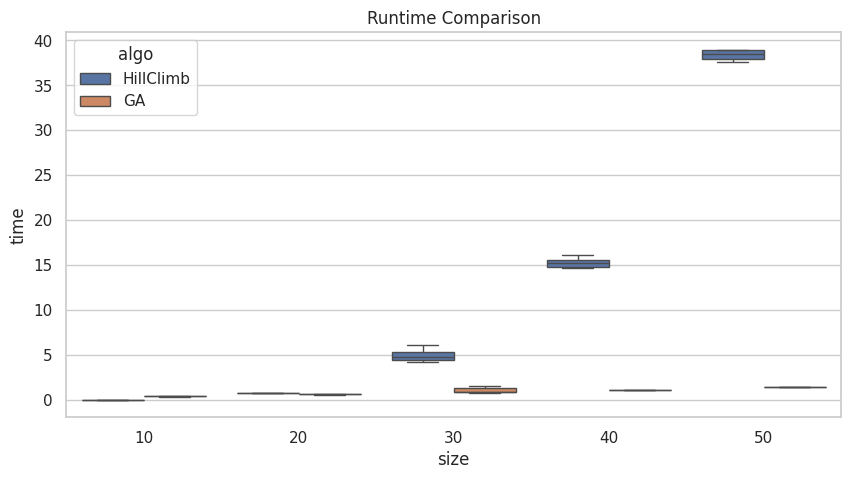

In [ ]:

plt.figure(figsize=(10,5))
sns.boxplot(data=df_res,x='size',y='distance',hue='algo')
plt.title('Distance Comparison')
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(data=df_res,x='size',y='time',hue='algo')
plt.title('Runtime Comparison')
plt.show()


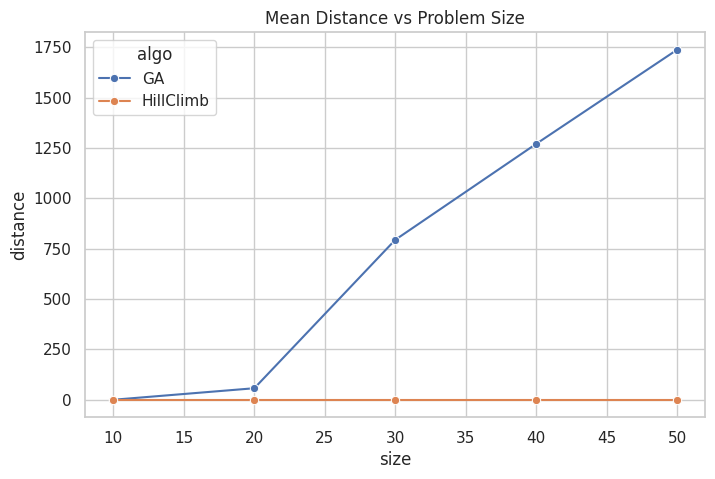

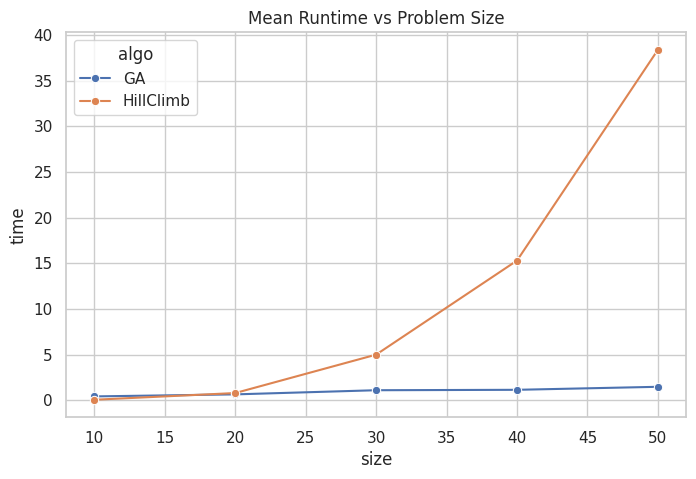

In [ ]:

avg=df_res.groupby(['size','algo'])['distance'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.lineplot(data=avg,x='size',y='distance',hue='algo',marker='o')
plt.title('Mean Distance vs Problem Size')
plt.show()

avgt=df_res.groupby(['size','algo'])['time'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.lineplot(data=avgt,x='size',y='time',hue='algo',marker='o')
plt.title('Mean Runtime vs Problem Size')
plt.show()


## Comparison Tables

In [ ]:

dist_table=df_res.groupby(['size','algo'])['distance'].agg(['mean','median','std'])
time_table=df_res.groupby(['size','algo'])['time'].agg(['mean','median','std'])
dist_table, time_table


(                       mean       median        std
 size algo                                          
 10   GA            0.000000     0.000000   0.000000
      HillClimb     0.000000     0.000000   0.000000
 20   GA           57.191266    30.856668  61.844602
      HillClimb     0.000000     0.000000   0.000000
 30   GA          793.779354   803.658314  70.425269
      HillClimb     0.000000     0.000000   0.000000
 40   GA         1270.023406  1273.426896  67.095951
      HillClimb     0.000000     0.000000   0.000000
 50   GA         1737.293041  1748.839184  38.294838
      HillClimb     0.000000     0.000000   0.000000,
                      mean     median       std
 size algo                                     
 10   GA          0.410775   0.405917  0.008785
      HillClimb   0.044055   0.044769  0.002050
 20   GA          0.633456   0.636034  0.013394
      HillClimb   0.778918   0.779514  0.021408
 30   GA          1.087590   0.878324  0.318711
      HillClimb   4.987817 